# Exploratory Data Analysis

In [101]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

This notebook focuses on Exploratory Data Analysis, the process of discovering key characteristics of a dataset through statistical visualisations. The main objective is to discover the most appropriate and coherent data modelling approach. 

In [77]:
# Importing the preprocessed data:
train = pd.read_pickle('../Data/Preprocessed/train_preprocessed.pkl')

## Pairplot

A pair plot is a grid of scatterplots depicting the relationship between two numerical features. The plots on the main diagonal represent each feature's distribution. The plot colours will be set to two groups corresponding to the two categories of the response variable. This will provide additional insight into these features' relationship with the response. 

In [78]:
# Select numerical data:
train.select_dtypes('number').head()

,id,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
0,70172,13,460,25,18.0
1,5047,25,235,1,6.0
2,110028,26,1142,0,0.0
3,24026,25,562,11,9.0
4,119299,61,214,0,0.0


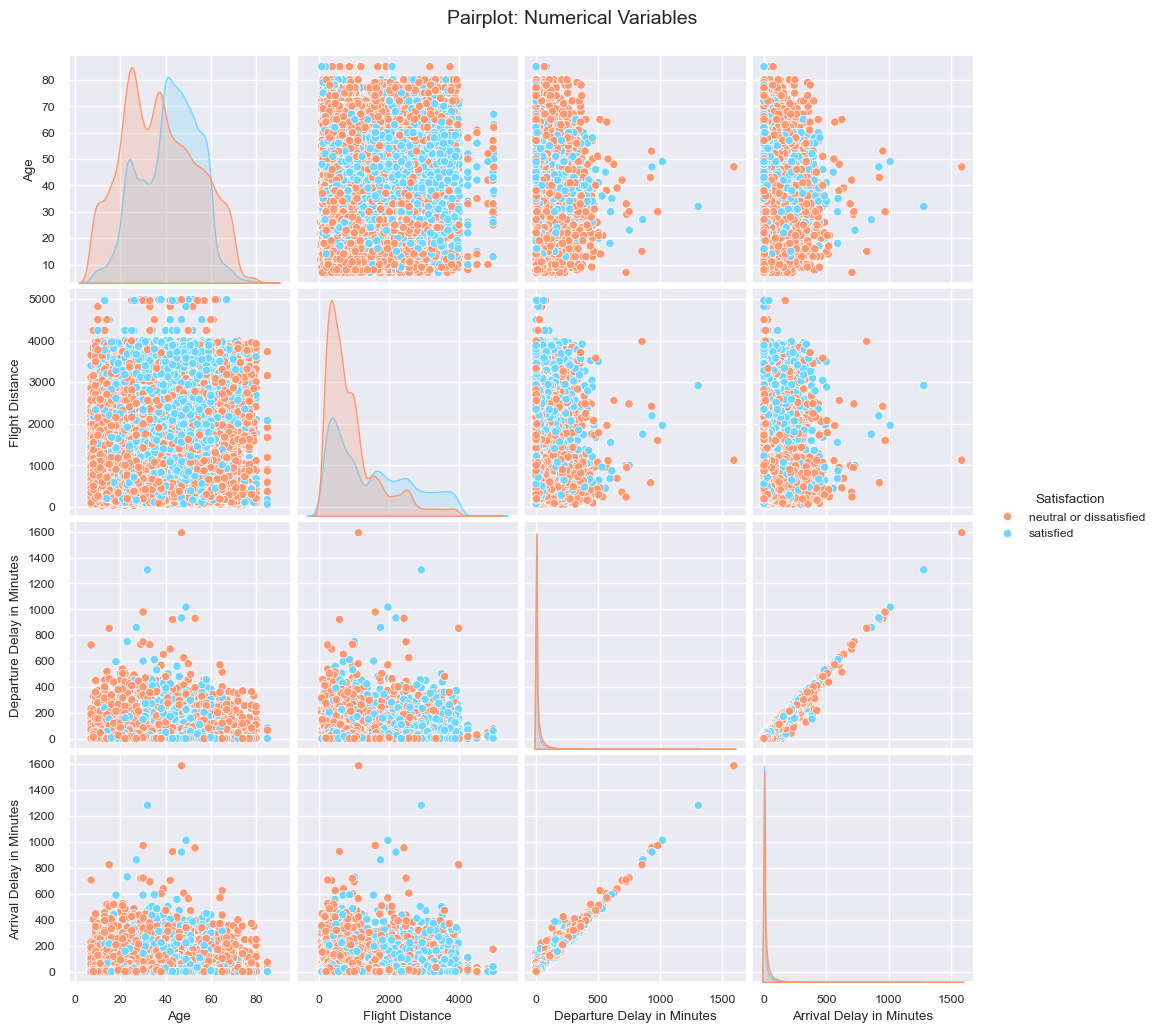

In [79]:
# Plotting the pairsplot with kde for the main diagonal:
hue_colors = {'neutral or dissatisfied': '#FF9770',
              'satisfied': '#70D6FF'}
ax = sns.pairplot(data = train, vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], 
             diag_kind = 'kde', hue = 'Satisfaction', palette = hue_colors)
ax.fig.suptitle('Pairplot: Numerical Variables', fontsize = 14, y = 1.03)
plt.show()

The first subplot (on the main diagonal) shows that many satisfied customers are middle-aged. The distribution of this plot resembles a bell-shaped curve. The second subplot on the main diagonal depicts more passengers going on shorter flights, and the distribution is right-skewed. There seem to be slightly more satisfied customers on longer flights. The other two subplots on the main diagonal simply show that delays (whether on departure or arrival) tend to be short; the distribution is extremely right-skewed. The off-diagonal plots show that departure and arrival delays are highly correlated. The two groups of customers, 'satisfied' and 'neutral or dissatisfied', are more or less equally spread among the age, distance and delay variables.

## Correlation Heatmaps

The next analysis will be performed using correlation heatmaps. The second preprocessed train set file is used for this analysis, since the calculation of correlation requires ordered categorical variables. 

In [80]:
# Importing the preprocessed data:
train = pd.read_pickle('../Data/Preprocessed/train_preprocessed_2.pkl')

Correlation heatmaps visualise the strength and direction of association between two variables. The darker the colour between two variables, the stronger the relationship. A correlation coefficient close to '1' means perfect positive correlation, '-1' means perfect negative correlation and '0' means no correlation. To create such a plot, the correlation between each pair of variables needs to be calculated. The default correlation metric calculated by pandas is the Spearman Correlation coefficient. Since the heatmap of interest includes categorical variables, an alternative correlation coefficient has to be set. Kendall's Tau correlation has been chosen because it is a non-parametric statistic that measures ordinal associations. Most of the features in the dataset are ordinal, which makes Kendall Tau's correlation ideal for this type of data [(Learn Statistics Easily, 2024)](#ref-learnstatseasy2024).

Kendall's Tau can be calculated as follows:

$$\tau = \frac{C-D}{C+D},$$

where $C$ is the number of concordant pairs, and $D$ is the number of discordant pairs. Concordance or discordance is determined by taking a pair of observations and comparing them with another pair of observations. If the direction of classification is the same, for example, both are larger than the items they are compared to, then they are concordant. Otherwise, if the direction of classification is different, then they are discordant [(Minitab Support, 2024)](#ref-minitab2024).



In [81]:
# Droppinng the `id` and nominal categorical variables:
train_corr_cat = train.drop(['id', 'Gender', 'Customer Type', 'Type of Travel'], axis = 1)

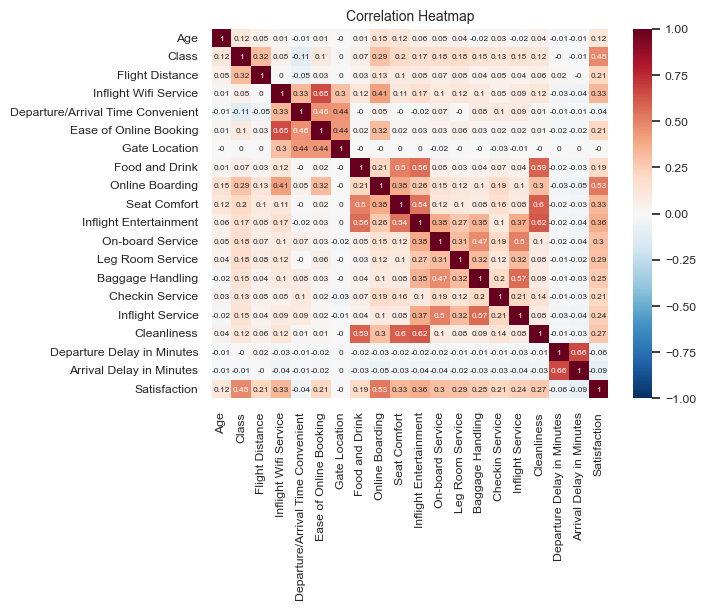

In [82]:
# Plotting the correlation heatmap:
sns.set(font_scale = 0.8)
ax = plt.axes()
rdbu_map= plt.get_cmap('RdBu')
reversed_map = rdbu_map.reversed()
sns.heatmap(round(train_corr_cat.corr(method = 'kendall'), 2), annot = True, cmap = reversed_map, annot_kws = {'size': 6}, vmin=-1, vmax=1, ax = ax)
ax.set_title('Correlation Heatmap', fontsize = 10)
plt.show()

The heatmap distinguishes three groups of positively correlated features. For example, `Food and Drink` is positively correlated to `Seat Comfort` and `Inflight Entertainment`; the latter are also positively correlated. Two features are strongly positively correlated with the response ‘Satisfaction’: ‘Class’ and ‘Online Boarding’. Other variables positively correlated with ‘Satisfaction’ include `Inflight Wifi Service`, `Seat Comfort`, `On-board Service`, and `Leg Room Service`. These are all promising variables in predicting the response, which should be examined further. When dealing with correlation, it is always important to remember that correlation does not imply causation. That is, even if a feature is correlated with the response, it does not mean that this feature causes the response outcome. In the case of positive correlation, it simply means that when a feature increases, the response also increases.  

Since the nominal categorical variables `Gender`, `Customer Type`, and `Type of Travel` could not be included in the correlation heatmap, a Chi-Square Test for independence will be performed on each combination of the variables (including the response) to check whether a relationship exists among these variables.

## Chi-Squared Test for Independence

The chi-square ($\chi^2$) test for independence is a non-parametric hypothesis test, which determines whether two categorical variables are related. It can be performed on binary, ordinal and nominal data types. In this case, the three variables of interest are nominal, and the response is binary. The null and alternative hypotheses are defined as follows:

**$H_0$: there is no association between the two variables tested. </br>
$H_1$: there is an association between the two variables tested; that is, the two variables are related** [(Turney, 2023)](#ref-turney2023).

In [86]:
# Importing the preprocessed data:
train = pd.read_pickle('../Data/Preprocessed/train_preprocessed.pkl')

In [87]:
# Defining a function to perform chi-squared tests of association:
def chi_square_test(contingency_table):
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f'Test results for the variables {contingency_table.index.names[0]} and {contingency_table.columns.names[0]}:')
    print(f'chi2_statistic: {round(chi2_stat, 2)}')
    print(f'p-value: {round(p_val, 2)}')

In [88]:
# Creating the first contingency table:
contingency_table_1 = pd.crosstab(train['Gender'], train['Customer Type'], margins = True)

# Applying the chi-squared test function:
chi_square_test(contingency_table_1)

Test results for the variables Gender and Customer Type:
chi2_statistic: 104.62
p-value: 0.0


The p-value is less than 0.05; therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests an association between `Gender` and `Customer Type`.

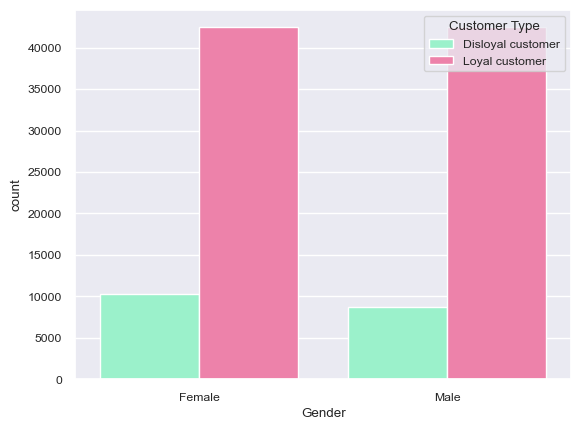

In [89]:
# Setting the palette dictionary:
hue_colors = {'Disloyal customer': '#8DFFCD',
              'Loyal customer': '#FF70A6'}

sns.countplot(x = 'Gender', hue = 'Customer Type', data = train, palette = hue_colors)
plt.show()

After plotting the two variables, it is clear that the test is somehow misleading. The problem here seems to be the fact that the sample size is very large and the p-values become unreliable. That is, the test will find statistical significance even with the slightest of differences between the features, which is what seems to be the case here. In order to decide on whether an association exists or not, a Cramer's V test of association will be performed.

The interpretation for Cramer's V test is provided below: [Akoglu, 2018](#ref-akoglu2018)

In [110]:
cramer = {"Cramer's V": ['>0.25', '>0.15', '>0.1', '>0.05', '>0'], 
          "Interpretation": ['Very strong', 'Strong', 'Moderate', 'Weak', 'No or Very Weak']}

cramer = pd.DataFrame(cramer)

print("Interpretation of Cramer's V Test:\n\n", cramer)

Interpretation of Cramer's V Test:

   Cramer's V   Interpretation
0      >0.25      Very strong
1      >0.15           Strong
2       >0.1         Moderate
3      >0.05             Weak
4         >0  No or Very Weak


In [111]:
print('Level of association:', association(contingency_table_1, method="cramer"))

Level of association: 0.0112188665832275


According to Cramer's V test, the association level is actually 'Very Weak'. This is confirmed by the count plot above, which shows that the proportion of 'Female' and 'Male' customers in terms of the 'Customer Type' is the same.

In [113]:
# Creating the second contingency table:
contingency_table_2 = pd.crosstab(train['Gender'], train['Type of Travel'], margins = True)

# Applying the chi-squared test function:
chi_square_test(contingency_table_2)

Test results for the variables Gender and Type of Travel:
chi2_statistic: 4.96
p-value: 0.29


The p-value is more than 0.05. Therefore, the null hypothesis can not be rejected at the 5% significance level. The test suggests no association between `Gender` and `Type of Travel`.

In [114]:
# Creating the third contingency table:
contingency_table_3 = pd.crosstab(train['Customer Type'], train['Type of Travel'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_3)

Test results for the variables Customer Type and Type of Travel:
chi2_statistic: 9876.36
p-value: 0.0


The p-value is less than 0.05; therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests an association between `Customer Type` and `Type of Travel`.

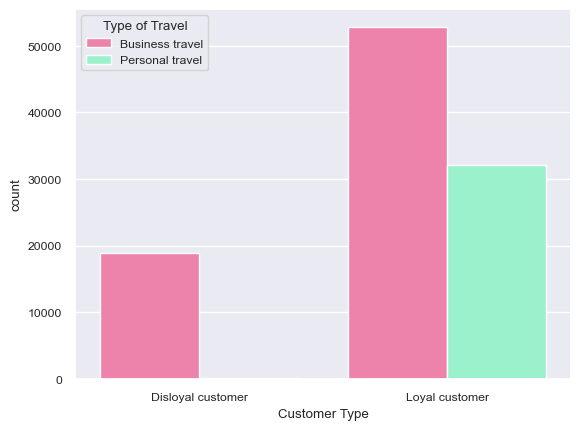

In [115]:
# Setting the palette dictionary:
hue_colors = {'Personal travel': '#8DFFCD',
              'Business travel': '#FF70A6'}

sns.countplot(x = 'Customer Type', hue = 'Type of Travel', data = train, palette = hue_colors)
plt.show()

This finding is confirmed when plotting the count plot for the two variables. It can be seen that all 'Personal travel' customers are 'Loyal'. There are no 'Personal travel' customers that are 'Disloyal'. 

In [116]:
# Creating the fourth contingency table:
contingency_table_4 = pd.crosstab(train['Satisfaction'], train['Type of Travel'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_4)

Test results for the variables Satisfaction and Type of Travel:
chi2_statistic: 20945.23
p-value: 0.0


The p-value is less than 0.05; therefore, the null hypothesis can be rejected at the 5% level of significance. The test suggests an association between `Satisfaction` and `Type of Travel`. Customers on business trips are more likely to be satisfied than those travelling for personal reasons.

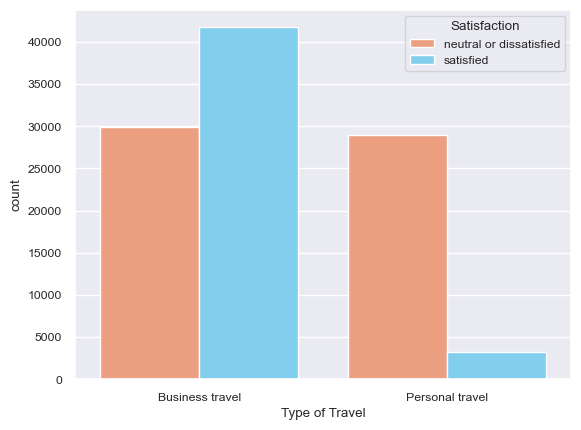

In [117]:
# Setting the palette dictionary:
hue_colors = {'neutral or dissatisfied': '#FF9770',
              'satisfied': '#70D6FF'}

sns.countplot(x = 'Type of Travel', hue = 'Satisfaction', data = train, palette = hue_colors)
plt.show()

In [120]:
print('Level of association:', association(contingency_table_4, method="cramer"))

Level of association: 0.4490004498438344


Again, a count plot confirms the findings from the chi-square test that there is an association between 'Satisfaction' and 'Type of Travel'. After performing a Cramer's V test, the association level is shown to be 'Very Strong'.

In [44]:
# Creating the fifth contingency table:
contingency_table_5 = pd.crosstab(train['Satisfaction'], train['Customer Type'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_5)

Test results for the variables Satisfaction and Customer Type:
chi2_statistic: 3657.28
p-value: 0.0


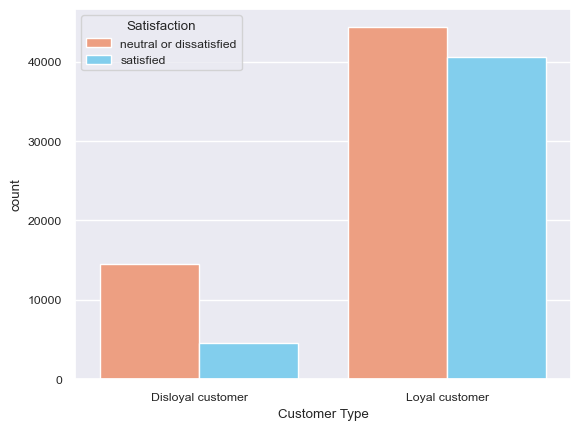

In [63]:
# Setting the palette dictionary:
hue_colors = {'neutral or dissatisfied': '#FF9770',
              'satisfied': '#70D6FF'}

sns.countplot(x = 'Customer Type', hue = 'Satisfaction', data = train, palette = hue_colors)
plt.show()

In [122]:
print('Level of association:', association(contingency_table_5, method="cramer"))

Level of association: 0.1876381714148105


The p-value is less than 0.05; therefore, the null hypothesis can be rejected at the 5% significance level. The test suggests an association between `Satisfaction` and `Customer Type`. Although the test does not explicitly state which customers are more likely to be satisfied, the count plot shows that loyal customers are more likely to be satisfied than disloyal customers. The association level is shown to be 'Strong' from Cramer's V test.

In [64]:
# Creating the sixth contingency table:
contingency_table_6 = pd.crosstab(train['Satisfaction'], train['Gender'])

# Applying the chi-squared test function:
chi_square_test(contingency_table_6)

Test results for the variables Satisfaction and Gender:
chi2_statistic: 15.44
p-value: 0.0


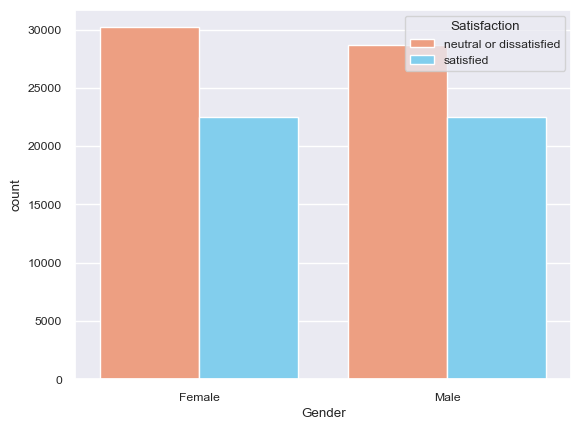

In [66]:
# Setting the palette dictionary:
hue_colors = {'neutral or dissatisfied': '#FF9770',
              'satisfied': '#70D6FF'}

sns.countplot(x = 'Gender', hue = 'Satisfaction', data = train, palette = hue_colors)
plt.show()

In [123]:
print('Level of association:', association(contingency_table_6, method="cramer"))

Level of association: 0.012211274713222281


The p-value is less than 0.05; therefore, the null hypothesis can be rejected at the 5% significance level. The test suggests an association between `Satisfaction` and `Gender`. When plotting the counts of 'Female' vs 'Male passengers, along with their satisfaction levels, it can be seen that there are slightly more female passengers. There does not seem to be much difference in the satisfaction levels among female and male passengers. After performing Cramer's V test of association, it is shown that the association level is actually 'Null or Very weak' (as confirmed by the plot).

## Count Plots

Count plots are presented to gain further insights into the relationship between the ordinal variables and the response `Satisfaction`. Only the six most strongly correlated variables are included in the analysis. Count plots are simple visuals depicting the count of observations in each category of the variable of interest. Here, the plots have been separated into ' satisfied' and 'neutral or dissatisfied' customers. 

In [57]:
# Importing the preprocessed data to ensure 'Satisfaction' is encoded nominally:
train = pd.read_pickle('../Data/Preprocessed/train_preprocessed.pkl')

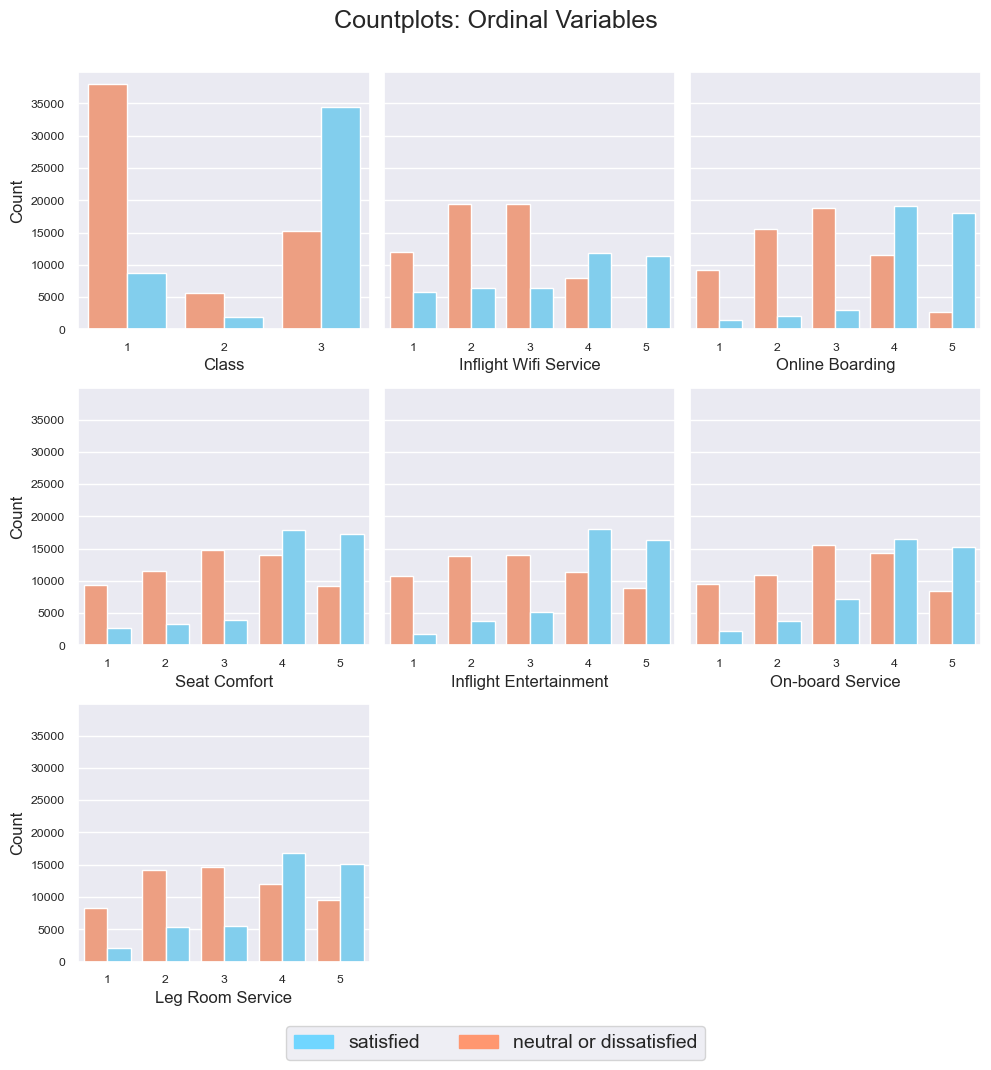

In [58]:
# Setting the palette dictionary:
hue_colors = {'neutral or dissatisfied': '#FF9770',
              'satisfied': '#70D6FF'}

# Defining the grid dimension and size of the plot:
fig, ax = plt.subplots(3, 3, sharey = True, figsize = (10, 10))

# Plotting the ordinal variables:
sns.countplot(ax = ax[0, 0], x = 'Class', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[0, 0].set_xlabel('Class', fontsize = 12)
ax[0, 0].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[0, 1], x = 'Inflight Wifi Service', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[0, 1].set_xlabel('Inflight Wifi Service', fontsize = 12)
ax[0, 1].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[0, 2], x = 'Online Boarding', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[0, 2].set_xlabel('Online Boarding', fontsize = 12)
ax[0, 2].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[1, 0], x = 'Seat Comfort', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[1, 0].set_xlabel('Seat Comfort', fontsize = 12)
ax[1, 0].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[1, 1], x = 'Inflight Entertainment', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[1, 1].set_xlabel('Inflight Entertainment', fontsize = 12)
ax[1, 1].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[1, 2], x = 'On-board Service', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[1, 2].set_xlabel('On-board Service', fontsize = 12)
ax[1, 2].set_ylabel('Count', fontsize = 12)
sns.countplot(ax = ax[2, 0], x = 'Leg Room Service', hue = 'Satisfaction', data = train, palette = hue_colors, legend=False)
ax[2, 0].set_xlabel('Leg Room Service', fontsize = 12)
ax[2, 0].set_ylabel('Count', fontsize = 12)

# Remove empty subplots
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])

# Creating the legend:
legend_labels = ['satisfied', 'neutral or dissatisfied']
legend_handles = [Patch(color=hue_colors[label], label=label) for label in legend_labels]
fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize = 14)

# Setting the title and other visual parameters:
plt.suptitle('Countplots: Ordinal Variables', fontsize = 18, y = 1.01)
plt.tight_layout()
plt.show()

In the `Class` subplot, the categories are `1`, `2`, and `3`, corresponding to the Economy, Economy Plus and Business classes. It can be seen that there are many dissatisfied passengers in Economy class (`1`). Conversely, there are many satisfied people in Business. By inspecting the other six plots, it can be seen that they all share a similar pattern. The dissatisfied passengers are distributed bell-shaped across the five categories, while most satisfied customers appear in the 4th and 5th categories. These most likely correspond to business-class services. 

## References

1.  <a id="ref-learnstatseasy2024"></a>Learn Statistics Easily, Kendall Tau-b vs Spearman: Which Correlation Coefficient Wins?, Learn Statistics Easily, 4 Jan 2024. [Link](https://statisticseasily.com/kendall-tau-b-vs-spearman/#) 

2. <a id="ref-minitab2024"></a> Minitab Support, What are Concordant and Discordant Pairs?, Minitab Support, 2024. [Link](https://support.minitab.com/en-us/minitab/help-and-how-to/statistics/tables/supporting-topics/other-statistics-and-tests/what-are-concordant-and-discordant-pairs/)


3. <a id="ref-turney2023"></a> Shaun Turney, Chi-Square Test of Independence | Formula, Guide and Examples, *Scribbr*, June 22, 2023. [Link](https://www.scribbr.com/statistics/chi-square-test-of-independence/#:~:text=A%20chi%2Dsquare%20test%20of%20independence%20works%20by%20comparing%20the,values%20of%20the%20other%20variable.&text=Example%3A%20Expected%20values%20The%20city,frequencies%20using%20the%20contingency%20table)

4. <a id="ref-akoglu2018"></a> Haldun Akoglu, User's Guide to Correlation Coefficients, *National Library of Medicine*, 7 August 2018. [Link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6107969/#:~:text=Cramer's%20V%20is%20an%20alternative,Cramer's%20V%20(Table%202).)